# Import requirements

In [118]:
import pandas as pd
import numpy as np
import geemap, ee
import matplotlib.pyplot as plt
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

# Call VIIIRS and Tehran Shapefiles

In [119]:
# Nighttime light data
viirs = ee.ImageCollection(
    "NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").select("avg_rad")
# NASA Climate
## climate = ee.ImageCollection("NASA/GPM_L3/IMERG_MONTHLY_V06")
# Terra Climate
## climate2 = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")

# FLDAS Climate
fldas = ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001")
# Tehran
teh = ee.FeatureCollection("users/amirhkiani1998/teh").select("Asrea").geometry()


# Having a look at the clipped VIIRS!

In [120]:
gisMap = geemap.Map()
gisMap.addLayer(viirs.mean().clip(teh))
gisMap.centerObject(teh)
gisMap

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [121]:
gisMap = geemap.Map()
gisMap.addLayer(fldas.mean(), {
                "bands": ["Rainf_f_tavg"],
                "palette": ["000000", "123456","234256", "452356","752829" , "ffffff"]})
gisMap.centerObject(teh)
gisMap


Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

# Getting GHSL in 2015

In [122]:
ghslList = ee.ImageCollection("JRC/GHSL/P2016/SMOD_POP_GLOBE_V1").toList(4)
ghslImage2015 = ee.Image(ghslList.get(3)) #2015-01-01

# Having a look at GHSL layer

In [123]:
gisMap = geemap.Map()
gisMap.addLayer(ghslImage2015.select("smod_code"), {
                "min": 0.0, "max": 3.0, "palette": ['000000', '448564', '70daa4', 'ffffff']})
gisMap.centerObject(teh)
gisMap


Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

# Getting VIIRS and climate in 2015 

In [124]:
viirs2015 = viirs.filterDate("2015-01-01", "2015-12-01").mean()
# climate2015 = climate.filterDate("2015-01-01", "2015-12-01").mean()
fldas2015 = fldas.filterDate("2015-01-01", "2015-12-01").mean()

# Add bands to each other

In [125]:
fusion = viirs2015.addBands(ghslImage2015).addBands(
    fldas2015.select(["Qg_tavg", "RadT_tavg", "Rainf_f_tavg"]))
fusionArray = fusion.sampleRegions(collection=teh, scale=2000).getInfo()

In [126]:
mainList = fusionArray["features"]
splitDict = []
for innerDict in mainList:
    splitDict.append(innerDict["properties"])
dataframe = pd.DataFrame(splitDict)
dataframe.head()

,Qg_tavg,RadT_tavg,Rainf_f_tavg,avg_rad,smod_code
0,1.478064,294.797424,0.000003,0.120778,0
1,1.478064,294.797424,0.000003,0.122011,0
2,1.478064,294.797424,0.000003,0.099779,0
3,1.478064,294.797424,0.000003,0.112499,0
4,1.478064,294.797424,0.000003,0.116815,0


# Check corrletion

In [127]:
dataframe.corr().style.background_gradient(cmap="coolwarm")

,Qg_tavg,RadT_tavg,Rainf_f_tavg,avg_rad,smod_code
Qg_tavg,1.000000,0.306151,-0.183977,0.555688,0.588446
RadT_tavg,0.306151,1.000000,-0.936672,0.251567,0.271237
Rainf_f_tavg,-0.183977,-0.936672,1.000000,-0.147756,-0.167580
avg_rad,0.555688,0.251567,-0.147756,1.000000,0.785679
smod_code,0.588446,0.271237,-0.167580,0.785679,1.000000


# Plotting the average radian against precipitation

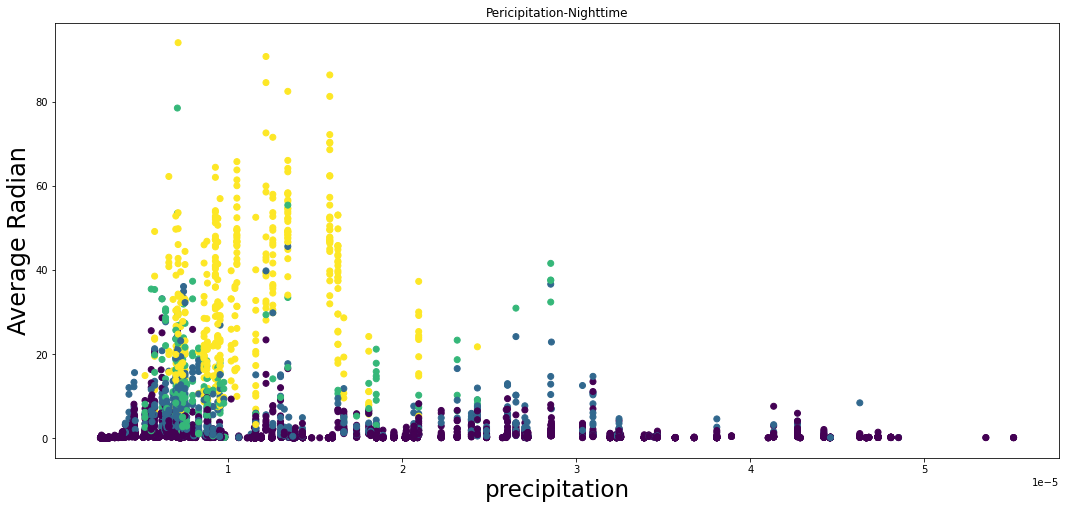

In [128]:
plt.figure(figsize=(18,8))
plt.title("Pericipitation-Nighttime")
plt.xlabel("precipitation", fontsize=23)
plt.ylabel("Average Radian", fontsize=24)
plt.scatter(dataframe.Rainf_f_tavg, dataframe.avg_rad, c=dataframe.smod_code)
plt.show()


# Plotting the average radian against precipitation just for urban and rural

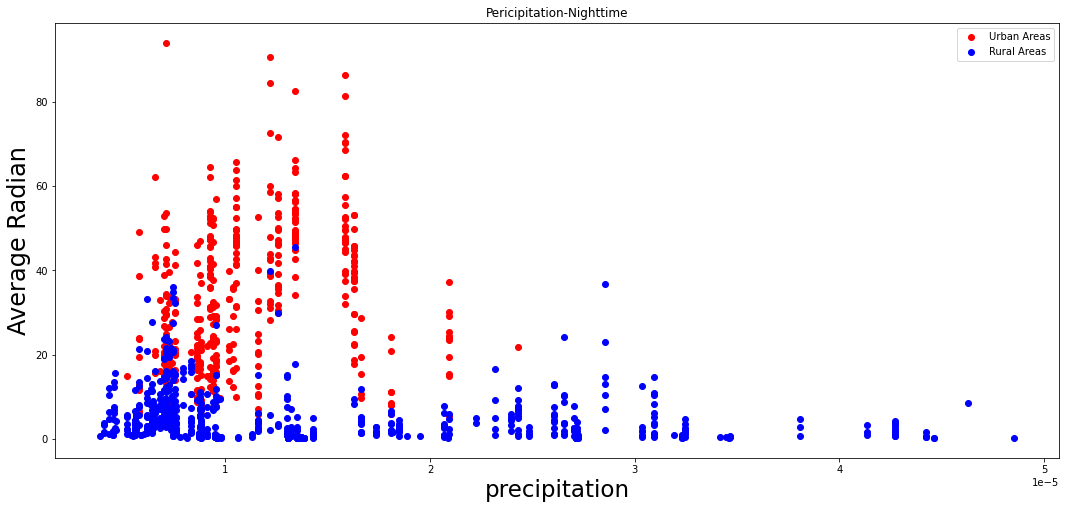

In [129]:
plt.figure(figsize=(18,8))
plt.title("Pericipitation-Nighttime")
plt.xlabel("precipitation", fontsize=23)
plt.ylabel("Average Radian", fontsize=24)
# urban
plt.scatter(dataframe[dataframe["smod_code"] == 3].Rainf_f_tavg, dataframe[dataframe["smod_code"] == 3].avg_rad, color="red", label="Urban Areas")
# rural
plt.scatter(dataframe[dataframe["smod_code"] == 1].Rainf_f_tavg, dataframe[dataframe["smod_code"] == 1].avg_rad, color="blue", label="Rural Areas")
plt.legend()
plt.show()

# Preparing train and test data (using Precipitation and Average Radian)

In [130]:
from sklearn.model_selection import train_test_split
# turning the features into a matrix (As a note, target data should not be turned into matrix)
X = np.c_[dataframe[(dataframe["smod_code"] == 1) | (dataframe["smod_code"] == 3)].Rainf_f_tavg.values,
          dataframe[(dataframe["smod_code"] == 1) | (dataframe["smod_code"] == 3)].avg_rad.values
          ]

y = dataframe[(dataframe["smod_code"] == 1) | (
    (dataframe["smod_code"] == 3))].smod_code.values.ravel()
# Preparing the train and test data(80% of the data are going to be train data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Classification (Linear)

In [131]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
svm_clf = Pipeline(
    [
        ("standard", StandardScaler()),
        ("linear_svc", LinearSVC(C=1 , loss="hinge", max_iter=12000))

])

# Fit the train to the model

In [132]:
svm_clf.fit(X_train, y_train)
print("Accuracy = ", round(svm_clf.score(X_test, y_test)*100), "%",sep="")

Accuracy = 91%


# Plot the Classification

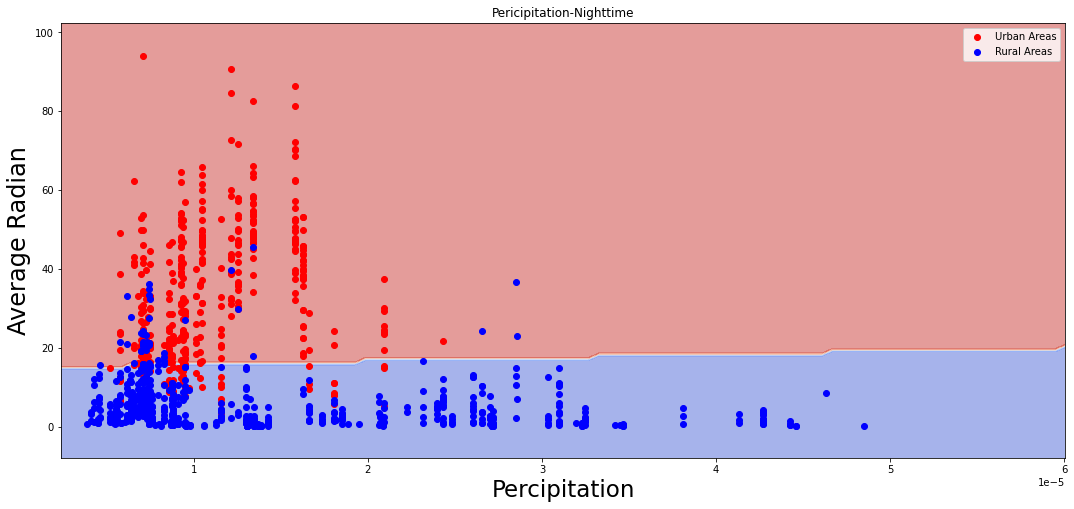

In [133]:
# The X axis (horizontal axis) is the percipitation
min_x, max_x = min(dataframe.Rainf_f_tavg.values)*0.9, max(dataframe.Rainf_f_tavg.values)*1.1
# The y axis (vertical axis) is the average radian
min_y, max_y = (min(dataframe.avg_rad.values)-10)*0.8, max(dataframe.avg_rad.values)*1.1
# define the steps
# step = 0.00005

xx , yy = np.meshgrid(np.arange(min_x, max_x, (max_x-min_x)/100), np.arange(min_y, max_y, (max_y-min_y)/100))
Z = svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(18, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.title("Pericipitation-Nighttime")
plt.xlabel("Percipitation", fontsize=23)
plt.ylabel("Average Radian", fontsize=24)
# urban
plt.scatter(dataframe[dataframe["smod_code"] == 3].Rainf_f_tavg,
            dataframe[dataframe["smod_code"] == 3].avg_rad, color="red", label="Urban Areas")
# rural
plt.scatter(dataframe[dataframe["smod_code"] == 1].Rainf_f_tavg,
            dataframe[dataframe["smod_code"] == 1].avg_rad, color="blue", label="Rural Areas")
plt.legend()
plt.show()

# SVM Classification (Non-Linear)

In [134]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
svm_clf_nonlinear = Pipeline(
    [
        ("standard", StandardScaler()),
        ("linear_svc", SVC(kernel="rbf", gamma=5, C=0.1))
    ])

# Fit the train data to model

In [135]:
svm_clf_nonlinear.fit(X_train, y_train)
print("Accuracy = ", round(svm_clf_nonlinear.score(X_test, y_test)*100), "%", sep="")


Accuracy = 92%


# Plot the classification

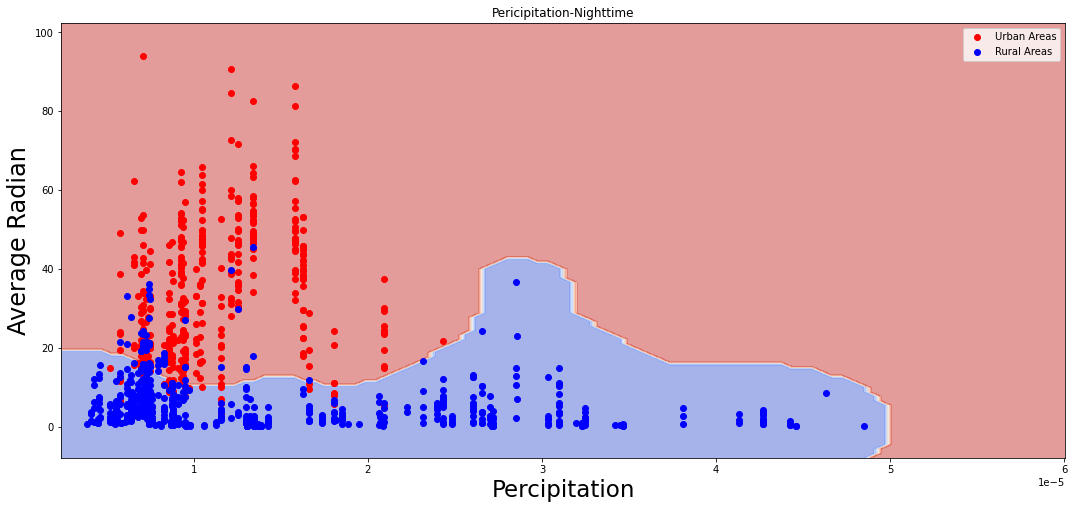

In [136]:
# The X axis (horizontal axis) is the percipitation
min_x, max_x = min(dataframe.Rainf_f_tavg.values) * \
    0.9, max(dataframe.Rainf_f_tavg.values)*1.1
# The y axis (vertical axis) is the average radian
min_y, max_y = (min(dataframe.avg_rad.values)-10) * \
    0.8, max(dataframe.avg_rad.values)*1.1
# define the steps
# step = 0.00005

xx, yy = np.meshgrid(np.arange(min_x, max_x, (max_x-min_x)/100),
                     np.arange(min_y, max_y, (max_y-min_y)/100))
Z = svm_clf_nonlinear.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(18, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.title("Pericipitation-Nighttime")
plt.xlabel("Percipitation", fontsize=23)
plt.ylabel("Average Radian", fontsize=24)
# urban
plt.scatter(dataframe[dataframe["smod_code"] == 3].Rainf_f_tavg,
            dataframe[dataframe["smod_code"] == 3].avg_rad, color="red", label="Urban Areas")
# rural
plt.scatter(dataframe[dataframe["smod_code"] == 1].Rainf_f_tavg,
            dataframe[dataframe["smod_code"] == 1].avg_rad, color="blue", label="Rural Areas")
plt.legend()
plt.show()


# SVM (Linear) Classification - 1D Classification

In [137]:
from sklearn.model_selection import train_test_split
dataframeCustom = dataframe[(dataframe["smod_code"]
                            == 1) | (dataframe["smod_code"] == 3)]
X2_train, X2_test, y2_train, y2_test = train_test_split(np.c_[dataframeCustom.avg_rad.values], dataframeCustom.smod_code.values, test_size = 0.2, random_state=42)


In [138]:
svm_clf.fit(X2_train, y2_train)
print("Accuracy = ", round(svm_clf.score(X2_test, y2_test)*100), "%", sep="")


Accuracy = 92%


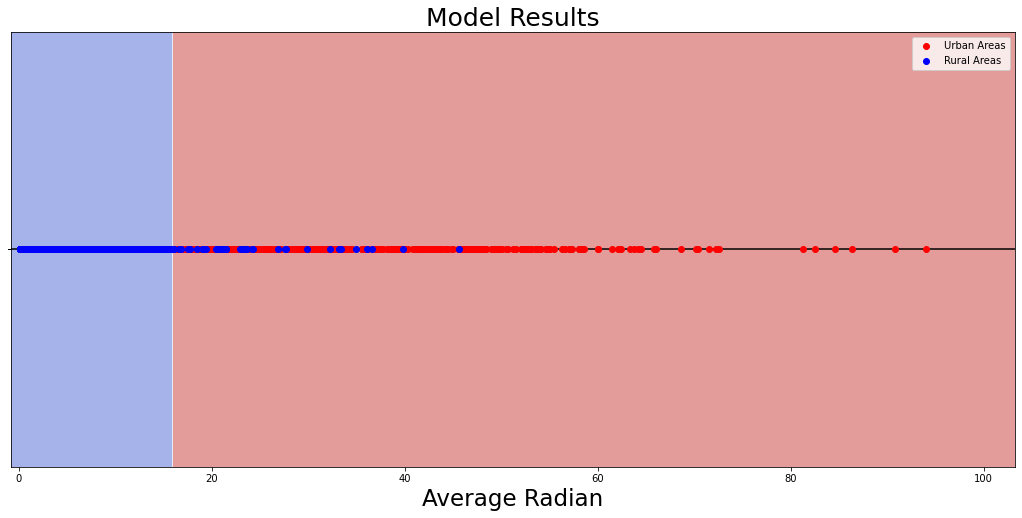

In [145]:
# The X axis (horizontal axis) is the precipitation
min_x, max_x = (min(dataframe.avg_rad.values)-1)*0.9, max(dataframe.avg_rad.values)*1.1
# The y axis (vertical axis) is the average radian
min_y, max_y = -1, +1

xx, yy = np.meshgrid(np.arange(min_x, max_x, (max_x-min_x)/500),
                     np.arange(min_y, max_y, (max_y-min_y)/500))
Z = svm_clf.predict(np.c_[xx.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(18, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.title("Model Results", fontsize=25)
plt.xlabel("Average Radian", fontsize=23)
# Draw the horizontal line on y = 0
plt.axhline(y=0, color="#000000", linestyle="-", zorder=1)
# Strip the vertical axis numbers
plt.yticks(np.full(dataframe[dataframe["smod_code"] == 1].avg_rad.shape, 0), "")
# urban
plt.scatter(dataframe[dataframe["smod_code"] == 3].avg_rad,
            np.full(dataframe[dataframe["smod_code"] == 3].avg_rad.shape,0), color="red", label="Urban Areas", zorder=5)
# rural
plt.scatter(dataframe[dataframe["smod_code"] == 1].avg_rad,
            np.full(dataframe[dataframe["smod_code"] == 1].avg_rad.shape,0), color="blue", label="Rural Areas", zorder=5)
plt.legend()
plt.show()

# SVM (Non-Linear) Classification - 1D Classification

In [146]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
svm_clf_nonlinear = Pipeline(
    [
        ("standard", StandardScaler()),
        ("linear_svc", SVC(kernel="rbf", gamma=5, C=0.1))
    ])

In [147]:
svm_clf_nonlinear.fit(X2_train, y2_train)
svm_clf_nonlinear.score(X2_test, y2_test)


0.918918918918919

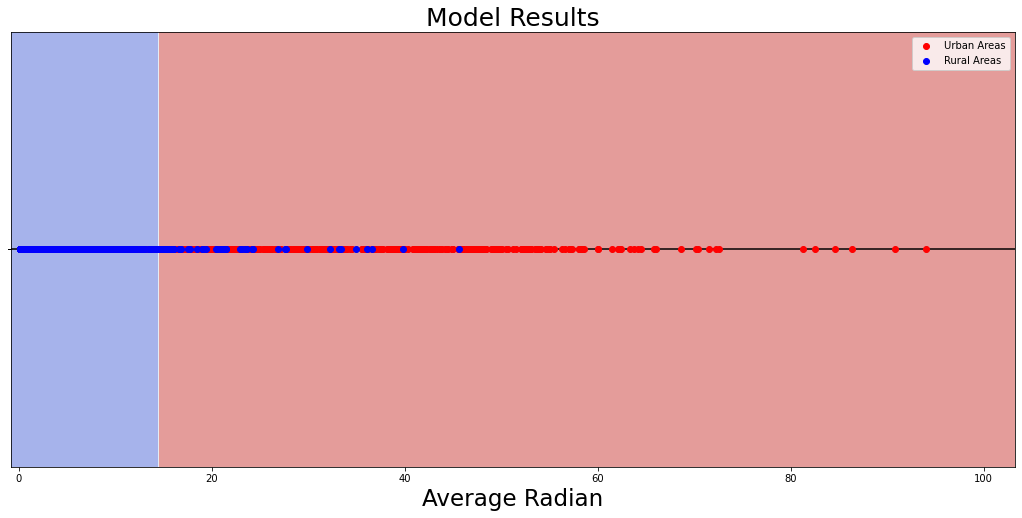

In [148]:
# The X axis (horizontal axis) is the precipitation
min_x, max_x = (min(dataframe.avg_rad.values)-1) * \
    0.9, max(dataframe.avg_rad.values)*1.1
# The y axis (vertical axis) is the average radian
min_y, max_y = -1, +1

xx, yy = np.meshgrid(np.arange(min_x, max_x, (max_x-min_x)/500),
                     np.arange(min_y, max_y, (max_y-min_y)/500))
Z = svm_clf_nonlinear.predict(np.c_[xx.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(18, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.title("Model Results", fontsize=25)
plt.xlabel("Average Radian", fontsize=23)
# Draw the horizontal line on y = 0
plt.axhline(y=0, color="#000000", linestyle="-", zorder=1)
# Strip the vertical axis numbers
plt.yticks(
    np.full(dataframe[dataframe["smod_code"] == 1].avg_rad.shape, 0), "")
# urban
plt.scatter(dataframe[dataframe["smod_code"] == 3].avg_rad,
            np.full(dataframe[dataframe["smod_code"] == 3].avg_rad.shape, 0), color="red", label="Urban Areas", zorder=5)
# rural
plt.scatter(dataframe[dataframe["smod_code"] == 1].avg_rad,
            np.full(dataframe[dataframe["smod_code"] == 1].avg_rad.shape, 0), color="blue", label="Rural Areas", zorder=5)
plt.legend()
plt.show()


# Check model in other provinces(Isfahan)

## Calling Isfahan geometry from google earth engine 

In [150]:
isf = ee.FeatureCollection("users/amirhkiani1998/isf").geometry()

## Making fusion data

In [198]:
fusionIsf = viirs2015.addBands(ghslImage2015).addBands(
    fldas2015.select(["Qg_tavg", "RadT_tavg", "Rainf_f_tavg"]))
fusionIsfArray = fusion.sampleRegions(collection=isf, scale=6000).getInfo()

## Making dataframe

In [199]:
mainList = fusionArray["features"]
splitDict = []
for innerDict in mainList:
    splitDict.append(innerDict["properties"])
dataframe = pd.DataFrame(splitDict)
dataframe.head()

,Qg_tavg,RadT_tavg,Rainf_f_tavg,avg_rad,smod_code
0,1.111789,299.599762,0.000003,0.131881,0
1,1.111789,299.599762,0.000003,0.133634,0
2,1.152412,300.251556,0.000003,0.157993,0
3,1.061548,300.777496,0.000003,0.200225,0
4,1.062706,300.143951,0.000003,1.620629,0


## Correlation matrix

In [200]:
dataframe.corr().style.background_gradient(cmap="coolwarm")

,Qg_tavg,RadT_tavg,Rainf_f_tavg,avg_rad,smod_code
Qg_tavg,1.000000,-0.033958,-0.443073,-0.053871,-0.113961
RadT_tavg,-0.033958,1.000000,-0.429047,0.012485,-0.010785
Rainf_f_tavg,-0.443073,-0.429047,1.000000,0.052059,0.119394
avg_rad,-0.053871,0.012485,0.052059,1.000000,0.126796
smod_code,-0.113961,-0.010785,0.119394,0.126796,1.000000


In [202]:
isfPrediction = svm_clf_nonlinear.score(np.c_[dataframe[(dataframe["smod_code"] == 1) | (dataframe["smod_code"] == 3)].avg_rad.values], dataframe[(dataframe["smod_code"] == 1) | (dataframe["smod_code"] == 3)].smod_code.values)


## Checking the predicition

In [203]:
isfPrediction

0.9574468085106383

# What if we use all the variables?

## Tehran

In [174]:
fusion = viirs2015.addBands(ghslImage2015).addBands(
    fldas2015.select(["Qg_tavg", "RadT_tavg", "Rainf_f_tavg"]))
fusionArray = fusion.sampleRegions(collection=teh, scale=2000).getInfo()
mainList = fusionArray["features"]
splitDict = []
for innerDict in mainList:
    splitDict.append(innerDict["properties"])
dataframe = pd.DataFrame(splitDict)
dataframe.head()


,Qg_tavg,RadT_tavg,Rainf_f_tavg,avg_rad,smod_code
0,1.478064,294.797424,0.000003,0.120778,0
1,1.478064,294.797424,0.000003,0.122011,0
2,1.478064,294.797424,0.000003,0.099779,0
3,1.478064,294.797424,0.000003,0.112499,0
4,1.478064,294.797424,0.000003,0.116815,0


In [176]:
X = np.c_[dataframe.Qg_tavg.values,
          dataframe.RadT_tavg.values,  dataframe.Rainf_f_tavg.values, dataframe.avg_rad.values]
y = dataframe.smod_code.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [177]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
svm_clf_nonlinear = Pipeline(
    [
        ("standard", StandardScaler()),
        ("linear_svc", SVC(kernel="rbf", gamma=5, C=0.1))
    ])

In [178]:
svm_clf_nonlinear.fit(X_train, y_train)
svm_clf_nonlinear.score(X_test, y_test)

0.7668639053254438

## Check For Isfahan

In [180]:
fusion = viirs2015.addBands(ghslImage2015).addBands(
    fldas2015.select(["Qg_tavg", "RadT_tavg", "Rainf_f_tavg"]))
fusionArray = fusion.sampleRegions(collection=isf, scale=6000).getInfo()
mainList = fusionArray["features"]
splitDict = []
for innerDict in mainList:
    splitDict.append(innerDict["properties"])
dataframe = pd.DataFrame(splitDict)
dataframe.head()

,Qg_tavg,RadT_tavg,Rainf_f_tavg,avg_rad,smod_code
0,1.402629,284.519989,0.000010,0.160859,0
1,1.402629,284.519989,0.000010,0.118554,0
2,1.241482,285.307892,0.000008,0.115122,0
3,1.286213,284.696198,0.000008,0.158833,1
4,1.130804,286.158783,0.000007,0.125732,0


In [181]:
X_isfahan = np.c_[dataframe.Qg_tavg.values,
          dataframe.RadT_tavg.values,  dataframe.Rainf_f_tavg.values, dataframe.avg_rad.values]
y_isfahan = dataframe.smod_code.values

In [182]:
svm_clf_nonlinear.score(X_isfahan, y_isfahan)

0.9426715617057329

## Check for Fars

In [190]:
fars = ee.FeatureCollection("users/amirhkiani1998/frs").geometry()
fusion = viirs2015.addBands(ghslImage2015).addBands(
    fldas2015.select(["Qg_tavg", "RadT_tavg", "Rainf_f_tavg"]))
fusionArray = fusion.sampleRegions(collection=fars, scale=6000).getInfo()
mainList = fusionArray["features"]
splitDict = []
for innerDict in mainList:
    splitDict.append(innerDict["properties"])
dataframe = pd.DataFrame(splitDict)
dataframe.head()


,Qg_tavg,RadT_tavg,Rainf_f_tavg,avg_rad,smod_code
0,1.111789,299.599762,0.000003,0.131881,0
1,1.111789,299.599762,0.000003,0.133634,0
2,1.152412,300.251556,0.000003,0.157993,0
3,1.061548,300.777496,0.000003,0.200225,0
4,1.062706,300.143951,0.000003,1.620629,0


In [191]:
X_fars = np.c_[dataframe.Qg_tavg.values,
          dataframe.RadT_tavg.values,  dataframe.Rainf_f_tavg.values, dataframe.avg_rad.values]
y_fars = dataframe.smod_code.values

In [192]:
svm_clf_nonlinear.score(X_fars, y_fars)

0.9350715746421268